In [1]:
import os
import random
import numpy as np
import librosa
import soundfile as sf

In [2]:
# ================= CONFIG =================
SAMPLE_RATE = 16000          # standard for speech
CLIP_DURATION = 4.0          # seconds
NUM_SAMPLES = int(SAMPLE_RATE * CLIP_DURATION)

NUM_NOISES_PER_CLEAN = 6
SNR_DB = 5

In [6]:
# ================= PATHS =================
DATASET_DIR = "data"
CLEAN_DIR = os.path.join(DATASET_DIR, "clean")
NOISE_DIR = os.path.join(DATASET_DIR, "noise")

OUT_DIR = "processed_data"
CLEAN_OUT = os.path.join(OUT_DIR, "clean_fixed")
NOISE_OUT = os.path.join(OUT_DIR, "noise_fixed")
NOISY_OUT = os.path.join(OUT_DIR, "mixed")

# ================= CREATE OUTPUT FOLDERS =================
os.makedirs(CLEAN_OUT, exist_ok=True)
os.makedirs(NOISE_OUT, exist_ok=True)
os.makedirs(NOISY_OUT, exist_ok=True)


In [7]:
# ================= FUNCTIONS =================

def load_audio(path, sr=SAMPLE_RATE):
    """
    Load audio file (wav or mp3) and return mono signal at sr
    """
    audio, _ = librosa.load(path, sr=sr, mono=True)
    return audio

def fix_length(audio, length=NUM_SAMPLES):
    """
    Trim or pad audio to fixed number of samples
    """
    if len(audio) > length:
        return audio[:length]
    elif len(audio) < length:
        return np.pad(audio, (0, length - len(audio)))
    return audio

def save_audio(path, audio, sr=SAMPLE_RATE):
    """
    Save audio to wav file
    """
    sf.write(path, audio, sr)

def collect_files_recursive(rootdir, extensions):
    """
    Collect all audio files recursively with specified extensions
    """
    files = []
    extensions = tuple(ext.lower() for ext in extensions)

    for root, dirs, filenames in os.walk(rootdir):
        for fname in filenames:
            if fname.lower().endswith(extensions):
                files.append(os.path.join(root, fname))
    return sorted(files)


In [8]:
def add_noise(clean, noise, snr_db=SNR_DB):
    """
    Add noise to clean audio at specified SNR
    """
    clean_power = np.mean(clean ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 ** (snr_db / 10)
    scale = np.sqrt(clean_power / (snr * noise_power))
    noisy = clean + scale * noise
    return noisy

In [9]:
def process_single_clean(clean_path, noise_files):
    """
    For one clean audio:
    - save fixed clean
    - randomly pick 6 different noises
    - save fixed noise and noisy mixes
    """
    # load & fix clean audio
    clean = load_audio(clean_path)
    clean = fix_length(clean)

    base_name = os.path.splitext(os.path.basename(clean_path))[0]

    # save clean
    clean_save_path = os.path.join(CLEAN_OUT, f"{base_name}.wav")
    save_audio(clean_save_path, clean)

    # pick 6 random noise files
    selected_noises = random.sample(noise_files, NUM_NOISES_PER_CLEAN)

    for idx, noise_path in enumerate(selected_noises, start=1):
        # load & fix noise
        noise = load_audio(noise_path)
        noise = fix_length(noise)

        # create noisy audio
        noisy = add_noise(clean, noise)

        # save noise
        noise_save_path = os.path.join(NOISE_OUT, f"{base_name}_noise_{idx}.wav")
        save_audio(noise_save_path, noise)

        # save noisy
        noisy_save_path = os.path.join(NOISY_OUT, f"{base_name}_mix_{idx}.wav")
        save_audio(noisy_save_path, noisy)

        print(f"Saved mix {idx} for {base_name}")

In [10]:
# ================= MAIN =================

# collect all clean and noise files
clean_files = collect_files_recursive(CLEAN_DIR, [".wav", ".mp3"])
noise_files = collect_files_recursive(NOISE_DIR, [".wav", ".mp3"])

print(f"Found {len(clean_files)} clean files")
print(f"Found {len(noise_files)} noise files")

if len(clean_files) == 0:
    raise RuntimeError("❌ No clean audio files found!")
if len(noise_files) < NUM_NOISES_PER_CLEAN:
    raise RuntimeError(f"❌ Not enough noise files (need at least {NUM_NOISES_PER_CLEAN})!")

# process each clean audio
for clean_path in clean_files:
    process_single_clean(clean_path, noise_files)

print("✅ Dataset generation completed!")

Found 1000 clean files
Found 260 noise files


d:\Audio Denoising\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Saved mix 1 for common_voice_en_42698997
Saved mix 2 for common_voice_en_42698997
Saved mix 3 for common_voice_en_42698997
Saved mix 4 for common_voice_en_42698997
Saved mix 5 for common_voice_en_42698997
Saved mix 6 for common_voice_en_42698997
Saved mix 1 for common_voice_en_42699001
Saved mix 2 for common_voice_en_42699001
Saved mix 3 for common_voice_en_42699001
Saved mix 4 for common_voice_en_42699001
Saved mix 5 for common_voice_en_42699001
Saved mix 6 for common_voice_en_42699001
Saved mix 1 for common_voice_en_42699868
Saved mix 2 for common_voice_en_42699868
Saved mix 3 for common_voice_en_42699868
Saved mix 4 for common_voice_en_42699868
Saved mix 5 for common_voice_en_42699868
Saved mix 6 for common_voice_en_42699868
Saved mix 1 for common_voice_en_42699890
Saved mix 2 for common_voice_en_42699890
Saved mix 3 for common_voice_en_42699890
Saved mix 4 for common_voice_en_42699890
Saved mix 5 for common_voice_en_42699890
Saved mix 6 for common_voice_en_42699890
Saved mix 1 for 

In [11]:
# STFT CONFIG
FFT_SIZE = 1024
HOP_LENGTH = 256
WINDOW = 'hann'

In [12]:
# Paths for saving STFT
STFT_OUT_DIR = "stft_data"
MAG_OUT = os.path.join(STFT_OUT_DIR, "magnitude")
PHASE_OUT = os.path.join(STFT_OUT_DIR, "phase")

os.makedirs(MAG_OUT, exist_ok=True)
os.makedirs(PHASE_OUT, exist_ok=True)

def compute_stft(audio, n_fft=FFT_SIZE, hop_length=HOP_LENGTH, window=WINDOW):
    """
    Compute STFT magnitude and phase
    """
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, window=window)
    magnitude = np.abs(stft)
    phase = np.angle(stft)
    return magnitude, phase

def save_stft(mag, phase, base_name):
    """
    Save magnitude and phase as .npy files
    """
    np.save(os.path.join(MAG_OUT, f"{base_name}_mag.npy"), mag)
    np.save(os.path.join(PHASE_OUT, f"{base_name}_phase.npy"), phase)


In [13]:
# Get all noisy audio files
noisy_files = [os.path.join(NOISY_OUT, f) for f in os.listdir(NOISY_OUT) if f.endswith(".wav")]
print(f"Found {len(noisy_files)} noisy files for STFT extraction")

for noisy_path in noisy_files:
    # Load audio
    audio, _ = librosa.load(noisy_path, sr=SAMPLE_RATE, mono=True)

    # Compute magnitude & phase
    mag, phase = compute_stft(audio)

    # Save
    base_name = os.path.splitext(os.path.basename(noisy_path))[0]
    save_stft(mag, phase, base_name)

    print(f"Saved STFT for {base_name}")

print("✅ STFT feature extraction completed!")

Found 6000 noisy files for STFT extraction
Saved STFT for common_voice_en_42698997_mix_1
Saved STFT for common_voice_en_42698997_mix_2
Saved STFT for common_voice_en_42698997_mix_3
Saved STFT for common_voice_en_42698997_mix_4
Saved STFT for common_voice_en_42698997_mix_5
Saved STFT for common_voice_en_42698997_mix_6
Saved STFT for common_voice_en_42699001_mix_1
Saved STFT for common_voice_en_42699001_mix_2
Saved STFT for common_voice_en_42699001_mix_3
Saved STFT for common_voice_en_42699001_mix_4
Saved STFT for common_voice_en_42699001_mix_5
Saved STFT for common_voice_en_42699001_mix_6
Saved STFT for common_voice_en_42699868_mix_1
Saved STFT for common_voice_en_42699868_mix_2
Saved STFT for common_voice_en_42699868_mix_3
Saved STFT for common_voice_en_42699868_mix_4
Saved STFT for common_voice_en_42699868_mix_5
Saved STFT for common_voice_en_42699868_mix_6
Saved STFT for common_voice_en_42699890_mix_1
Saved STFT for common_voice_en_42699890_mix_2
Saved STFT for common_voice_en_426998

In [15]:
import matplotlib.pyplot as plt

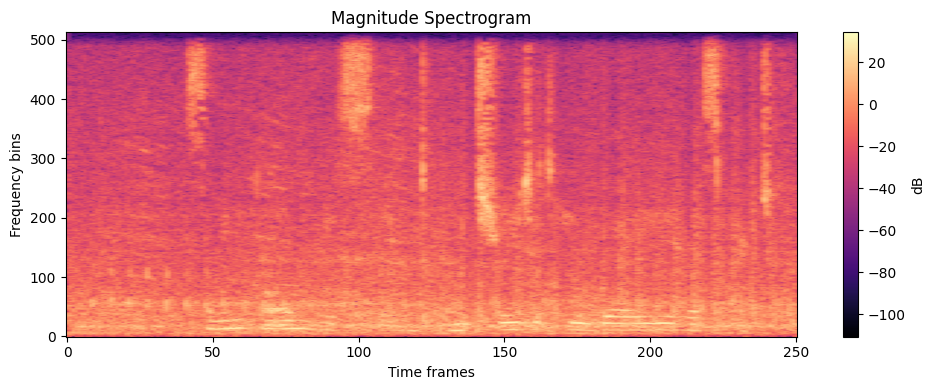

In [24]:
# ================= PICK ONE STFT =================
mag_path = "stft_data/magnitude/common_voice_en_42698997_mix_6_mag.npy"  # replace with your file

# ================= LOAD MAGNITUDE =================
mag = np.load(mag_path)

# ================= PLOT =================
plt.figure(figsize=(10, 4))
plt.imshow(
    20 * np.log10(mag + 1e-6),  # convert to dB
    origin='lower',
    aspect='auto',
    cmap='magma'
)
plt.colorbar(label="dB")
plt.xlabel("Time frames")
plt.ylabel("Frequency bins")
plt.title("Magnitude Spectrogram")
plt.tight_layout()
plt.show()
